In [24]:
import pandas as pd
import numpy as np
import lifelines
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
import seaborn as sns
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis

In [2]:
train = pd.read_csv('HCT/train.csv', index_col='ID')
train.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
ID,,,,,,,,,,,,,,,,,,,,,
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [3]:
test = pd.read_csv('HCT/test.csv', index_col='ID')
test

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
ID,,,,,,,,,,,,,,,,,,,,,
28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [4]:
data_description = pd.read_csv('HCT/data_dictionary.csv')
data_description

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN
5,hla_high_res_8,Recipient / 1st donor allele-level (high resol...,Numerical,NaN
6,tbi_status,TBI,Categorical,"['No TBI' 'TBI + Cy +- Other' 'TBI +- Other, <..."
7,arrhythmia,Arrhythmia,Categorical,['No' nan 'Yes' 'Not done']
8,hla_low_res_6,Recipient / 1st donor antigen-level (low resol...,Numerical,NaN
9,graft_type,Graft type,Categorical,['Peripheral blood' 'Bone marrow']


In [5]:
cat_cols = []
num_cols = []
for v, t in data_description[['variable', 'type']].values:
    if t == 'Categorical' and v != 'efs':
        cat_cols.append(v)
    elif not v in ['efs_time', 'efs']:
        num_cols.append(v)

In [5]:
num_cols

['hla_match_c_high',
 'hla_high_res_8',
 'hla_low_res_6',
 'hla_high_res_6',
 'hla_high_res_10',
 'hla_match_dqb1_high',
 'hla_nmdp_6',
 'hla_match_c_low',
 'hla_match_drb1_low',
 'hla_match_dqb1_low',
 'year_hct',
 'hla_match_a_high',
 'donor_age',
 'hla_match_b_low',
 'age_at_hct',
 'hla_match_a_low',
 'hla_match_b_high',
 'comorbidity_score',
 'karnofsky_score',
 'hla_low_res_8',
 'hla_match_drb1_high',
 'hla_low_res_10']

In [11]:
cat_cols

['dri_score',
 'psych_disturb',
 'cyto_score',
 'diabetes',
 'tbi_status',
 'arrhythmia',
 'graft_type',
 'vent_hist',
 'renal_issue',
 'pulm_severe',
 'prim_disease_hct',
 'cmv_status',
 'tce_imm_match',
 'rituximab',
 'prod_type',
 'cyto_score_detail',
 'conditioning_intensity',
 'ethnicity',
 'obesity',
 'mrd_hct',
 'in_vivo_tcd',
 'tce_match',
 'hepatic_severe',
 'prior_tumor',
 'peptic_ulcer',
 'gvhd_proph',
 'rheum_issue',
 'sex_match',
 'race_group',
 'hepatic_mild',
 'tce_div_match',
 'donor_related',
 'melphalan_dose',
 'cardiac',
 'pulm_moderate']

In [21]:
train[cat_cols].isna().sum().sort_values(ascending=False)

tce_match                 18996
mrd_hct                   16597
cyto_score_detail         11923
tce_div_match             11396
tce_imm_match             11133
cyto_score                 8068
conditioning_intensity     4789
cardiac                    2542
peptic_ulcer               2419
arrhythmia                 2202
rheum_issue                2183
rituximab                  2148
pulm_severe                2135
diabetes                   2119
psych_disturb              2062
pulm_moderate              2047
hepatic_mild               1917
renal_issue                1915
hepatic_severe             1871
obesity                    1760
prior_tumor                1678
melphalan_dose             1405
cmv_status                  634
ethnicity                   587
sex_match                   261
vent_hist                   259
in_vivo_tcd                 225
gvhd_proph                  225
donor_related               158
dri_score                   154
prod_type                     0
race_gro

In [6]:
train = pd.get_dummies(train, columns=cat_cols)

In [27]:
train.isna().sum()

hla_match_c_high          4620
hla_high_res_8            5829
hla_low_res_6             3270
hla_high_res_6            5284
hla_high_res_10           7163
                          ... 
cardiac_Not done             0
cardiac_Yes                  0
pulm_moderate_No             0
pulm_moderate_Not done       0
pulm_moderate_Yes            0
Length: 185, dtype: int64

In [73]:
train[num_cols].isna().sum().sort_values(ascending=False)

hla_high_res_10        7163
hla_high_res_8         5829
hla_high_res_6         5284
hla_match_dqb1_high    5199
hla_low_res_10         5064
hla_match_c_high       4620
hla_match_a_high       4301
hla_nmdp_6             4197
hla_match_dqb1_low     4194
hla_match_b_high       4088
hla_low_res_8          3653
hla_match_drb1_high    3352
hla_low_res_6          3270
hla_match_c_low        2800
hla_match_drb1_low     2643
hla_match_b_low        2565
hla_match_a_low        2390
donor_age              1808
karnofsky_score         870
comorbidity_score       477
year_hct                  0
age_at_hct                0
dtype: int64

In [53]:
train[num_cols].isna().sum().sort_values(ascending=False).index.values

array(['hla_high_res_10', 'hla_high_res_8', 'hla_high_res_6',
       'hla_match_dqb1_high', 'hla_low_res_10', 'hla_match_c_high',
       'hla_match_a_high', 'hla_nmdp_6', 'hla_match_dqb1_low',
       'hla_match_b_high', 'hla_low_res_8', 'hla_match_drb1_high',
       'hla_low_res_6', 'hla_match_c_low', 'hla_match_drb1_low',
       'hla_match_b_low', 'hla_match_a_low', 'donor_age',
       'karnofsky_score', 'comorbidity_score', 'year_hct', 'age_at_hct'],
      dtype=object)

In [7]:
hla_cols = []
for x in train[num_cols].isna().sum().sort_values(ascending=False).index.values:
    if 'hla' in x:
        hla_cols.append(x)
hla_cols

['hla_high_res_10',
 'hla_high_res_8',
 'hla_high_res_6',
 'hla_match_dqb1_high',
 'hla_low_res_10',
 'hla_match_c_high',
 'hla_match_a_high',
 'hla_nmdp_6',
 'hla_match_dqb1_low',
 'hla_match_b_high',
 'hla_low_res_8',
 'hla_match_drb1_high',
 'hla_low_res_6',
 'hla_match_c_low',
 'hla_match_drb1_low',
 'hla_match_b_low',
 'hla_match_a_low']

In [140]:
train['race_group'].value_counts()

KeyError: 'race_group'

In [6]:
gb = train[num_cols + ['race_group']].groupby('race_group', as_index=False).mean()
gb

,race_group,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10
0,American Indian or Alaska Native,1.746456,6.756298,5.050378,5.009045,8.456584,1.699695,5.061823,1.741148,1.672234,...,42.304974,1.698813,37.489555,1.685141,1.672170,1.703680,84.306427,6.794911,1.667931,8.529542
1,Asian,1.805357,7.105479,5.330814,5.295308,8.907463,1.798965,5.352914,1.803372,1.783301,...,45.835759,1.769969,42.238882,1.774755,1.750745,1.828757,82.754364,7.134081,1.771538,8.958926
2,Black or African-American,1.663090,6.333168,4.733712,4.677154,7.933193,1.627810,4.755351,1.646755,1.598885,...,42.027128,1.594583,36.272982,1.548223,1.569800,1.421086,84.443729,6.376126,1.581296,8.015166
3,More than one race,1.801302,7.047668,5.258573,5.238416,8.820851,1.764415,5.281818,1.800180,1.739179,...,41.485777,1.761364,34.102724,1.758079,1.746686,1.649476,84.811402,7.061253,1.741801,8.847338
4,Native Hawaiian or other Pacific Islander,1.670430,6.475581,4.866549,4.813047,8.114071,1.646470,4.886339,1.672211,1.624146,...,43.444913,1.624819,39.323117,1.627526,1.598104,1.865769,83.720828,6.537809,1.613688,8.203816
5,White,1.888835,7.464330,5.588562,5.570626,9.350813,1.868959,5.591329,1.876495,1.864391,...,39.950136,1.862955,42.553354,1.854882,1.848197,1.746340,82.980830,7.470354,1.857143,9.356472


In [7]:
gb_cols = gb.drop(columns='race_group').columns.values
gb_cols

array(['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6',
       'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high',
       'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age',
       'hla_match_b_low', 'age_at_hct', 'hla_match_a_low',
       'hla_match_b_high', 'comorbidity_score', 'karnofsky_score',
       'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10'],
      dtype=object)

In [8]:
merge_cols = gb_cols + '_gb'

In [9]:
train[merge_cols] = 0

In [10]:
gb_dict = {}
for r in gb['race_group'].values:
    sub_df = train[train['race_group'] == r]
    sub_df[merge_cols] = gb[gb['race_group'] == r].drop(columns='race_group').values.tolist() * len(sub_df)
    gb_dict[r] = sub_df

/tmp/ipykernel_46790/696181684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[merge_cols] = gb[gb['race_group'] == r].drop(columns='race_group').values.tolist() * len(sub_df)
/tmp/ipykernel_46790/696181684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[merge_cols] = gb[gb['race_group'] == r].drop(columns='race_group').values.tolist() * len(sub_df)
/tmp/ipykernel_46790/696181684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [22]:
gb_dict

{'American Indian or Alaska Native':               dri_score psych_disturb    cyto_score diabetes  \
 ID                                                             
 4                  High            No           NaN       No   
 8          Intermediate            No         Other       No   
 9          Intermediate            No  Intermediate       No   
 12                  Low            No          Poor       No   
 21                  Low            No           NaN       No   
 ...                 ...           ...           ...      ...   
 28756  TBD cytogenetics            No          Poor       No   
 28763      Intermediate            No  Intermediate       No   
 28766   N/A - pediatric            No           TBD       No   
 28772      Intermediate            No  Intermediate       No   
 28773      Intermediate            No           NaN       No   
 
        hla_match_c_high  hla_high_res_8           tbi_status arrhythmia  \
 ID                                      

In [11]:
for x in gb_dict.keys():
    train.loc[train['race_group'] == x] = gb_dict[x]

/tmp/ipykernel_46790/101356635.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.74645583 1.74645583 1.74645583 ... 1.74645583 1.74645583 1.74645583]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train['race_group'] == x] = gb_dict[x]
/tmp/ipykernel_46790/101356635.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.7562976 6.7562976 6.7562976 ... 6.7562976 6.7562976 6.7562976]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train['race_group'] == x] = gb_dict[x]
/tmp/ipykernel_46790/101356635.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5.05037783 5.05037783 5.05037783 ... 5.05037783 5.05037783 5.05037783]' has dtype incompatible with int64, please expl

In [24]:
train

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,donor_age_gb,hla_match_b_low_gb,age_at_hct_gb,hla_match_a_low_gb,hla_match_b_high_gb,comorbidity_score_gb,karnofsky_score_gb,hla_low_res_8_gb,hla_match_drb1_high_gb,hla_low_res_10_gb
ID,,,,,,,,,,,,,,,,,,,,,
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,...,41.485777,1.761364,34.102724,1.758079,1.746686,1.649476,84.811402,7.061253,1.741801,8.847338
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,...,45.835759,1.769969,42.238882,1.774755,1.750745,1.828757,82.754364,7.134081,1.771538,8.958926
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,41.485777,1.761364,34.102724,1.758079,1.746686,1.649476,84.811402,7.061253,1.741801,8.847338
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,39.950136,1.862955,42.553354,1.854882,1.848197,1.746340,82.980830,7.470354,1.857143,9.356472
4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,42.304974,1.698813,37.489555,1.685141,1.672170,1.703680,84.306427,6.794911,1.667931,8.529542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,41.485777,1.761364,34.102724,1.758079,1.746686,1.649476,84.811402,7.061253,1.741801,8.847338
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,Peripheral blood,...,43.444913,1.624819,39.323117,1.627526,1.598104,1.865769,83.720828,6.537809,1.613688,8.203816
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,Peripheral blood,...,43.444913,1.624819,39.323117,1.627526,1.598104,1.865769,83.720828,6.537809,1.613688,8.203816


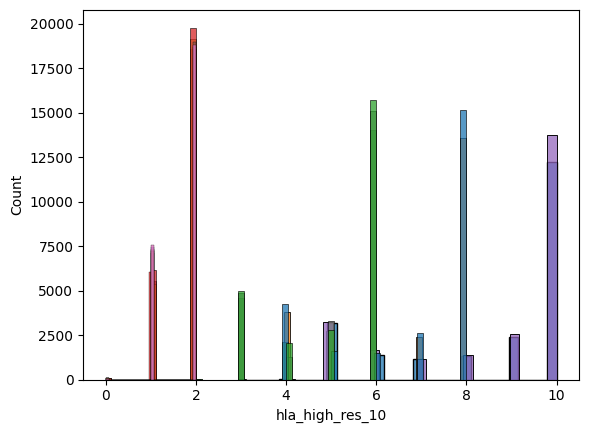

In [60]:
for x in hla_cols:
    sns.histplot(train[x])

In [50]:
train['year_hct'].mode()

0    2018
Name: year_hct, dtype: int64

In [8]:
mean_imputer = SimpleImputer(strategy='mean')
most_freq_imputer = SimpleImputer(strategy='most_frequent')

In [9]:
mode_cols = ['donor_age', ]

In [10]:
train[mode_cols] = most_freq_imputer.fit_transform(train[mode_cols])

In [11]:
train[hla_cols] = mean_imputer.fit_transform(train[hla_cols])

In [12]:
def fill_const_nan(df: pd.DataFrame):
    df['karnofsky_score'] = df['karnofsky_score'].fillna(70)
    df['comorbidity_score'] = df['comorbidity_score'].fillna(-1)
    return df

In [13]:
train = fill_const_nan(train)

In [180]:
train[num_cols].isna().sum()

hla_match_c_high       0
hla_high_res_8         0
hla_low_res_6          0
hla_high_res_6         0
hla_high_res_10        0
hla_match_dqb1_high    0
hla_nmdp_6             0
hla_match_c_low        0
hla_match_drb1_low     0
hla_match_dqb1_low     0
year_hct               0
hla_match_a_high       0
donor_age              0
hla_match_b_low        0
age_at_hct             0
hla_match_a_low        0
hla_match_b_high       0
comorbidity_score      0
karnofsky_score        0
hla_low_res_8          0
hla_match_drb1_high    0
hla_low_res_10         0
dtype: int64

In [14]:
train.isna().sum().sort_values()

hla_match_c_high        0
obesity_No              0
obesity_Not done        0
obesity_Yes             0
mrd_hct_Negative        0
                       ..
renal_issue_Not done    0
renal_issue_Yes         0
pulm_severe_No          0
arrhythmia_Not done     0
pulm_moderate_Yes       0
Length: 185, dtype: int64

In [10]:
train[cat_cols] = train[cat_cols].fillna('NaN')

In [17]:
def label_encoding(df: pd.DataFrame):
    df['label'] = 0
    df.loc[df['efs'] == 0, 'label'] = -df.loc[df['efs'] == 0, 'efs_time']
    df.loc[df['efs'] == 1, 'label'] = df.loc[df['efs'] == 1, 'efs_time']
    return df

In [18]:
train = label_encoding(train)
train

/tmp/ipykernel_859/1474047858.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -42.356  -19.793 -102.349 ...  -23.157  -52.351  -25.158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['efs'] == 0, 'label'] = -df.loc[df['efs'] == 0, 'efs_time']


,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,label
ID,,,,,,,,,,,,,,,,,,,,,
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,-42.356
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,...,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,4.672
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,-19.793
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,-102.349
4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,-16.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633,-18.633
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,Peripheral blood,...,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892,4.892
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,Peripheral blood,...,Unrelated,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,23.157,-23.157


In [21]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=['efs', 'efs_time']), train[['efs', 'efs_time', 'label']], stratify=train['efs'], test_size=0.2, random_state=12)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=['efs', 'efs_time']), train[['efs', 'efs_time']], stratify=train['efs'], test_size=0.2, random_state=12)

In [32]:
skcox = CoxnetSurvivalAnalysis()

In [26]:
skcox1 = GradientBoostingSurvivalAnalysis(verbose=3)

In [17]:
y_train['efs'] = y_train['efs'].astype(bool)

In [152]:
y_train

,efs,efs_time
ID,,
284,False,43.303
8162,False,41.042
12962,False,23.839
9092,False,32.851
19357,False,27.349
...,...,...
13696,False,30.256
3287,True,12.369
2171,True,8.162


In [155]:
y_train.values

array([[False, 43.303],
       [False, 41.042],
       [False, 23.839],
       ...,
       [True, 8.162],
       [True, 6.565],
       [False, 43.062]], dtype=object)

In [163]:
aux = [(e1,e2) for e1,e2 in y_train.values]

In [166]:
aux = np.array(aux, dtype=(bool, float))

ValueError: mismatch in size of old and new data-descriptor

In [160]:
aux

array([[ 0.   , 43.303],
       [ 0.   , 41.042],
       [ 0.   , 23.839],
       ...,
       [ 1.   ,  8.162],
       [ 1.   ,  6.565],
       [ 0.   , 43.062]])

In [33]:
skcox.fit(X_train, y_train.to_records(index=False))

CoxnetSurvivalAnalysis()

In [28]:
skcox1.fit(X_train, y_train.to_records(index=False))

      Iter       Train Loss   Remaining Time 
         1      120437.5515            9.60m
         2      120339.0676            9.64m
         3      120249.7113            9.53m
         4      120168.2114            9.42m
         5      120092.3460            9.30m
         6      120018.0673            9.18m
         7      119953.9496            9.09m
         8      119889.9947            8.99m
         9      119833.3858            8.89m
        10      119778.0231            8.80m
        11      119729.1215            8.71m
        12      119681.2137            8.60m
        13      119638.6261            8.49m
        14      119596.6032            8.39m
        15      119558.8978            8.29m
        16      119508.6131            8.19m
        17      119473.9184            8.09m
        18      119429.7439            7.99m
        19      119399.4882            7.89m
        20      119368.9737            7.79m
        21      119331.3924            7.69m
        2

GradientBoostingSurvivalAnalysis(verbose=3)

In [34]:
preds0 = skcox.predict(X_val)
preds0

array([ 1.13652249, -0.04966977,  1.12582024, ...,  0.33434931,
        0.98441817, -0.31639051])

In [29]:
preds = skcox1.predict(X_val)
preds

array([ 0.4599296 , -0.08879227,  0.3451093 , ...,  0.36790208,
        0.58622329, -0.07136854])

In [21]:
del rf

In [7]:
y_val

,efs,efs_time
ID,,
725,0.0,94.782
21229,1.0,7.961
10787,1.0,3.529
28558,0.0,34.658
14905,1.0,6.560
...,...,...
4493,0.0,28.770
582,0.0,53.361
8307,0.0,48.064


In [20]:
train1, val1 = train_test_split(train, test_size=0.2)

In [244]:
val1['efs']

ID
23684    0.0
16746    1.0
13915    0.0
3551     1.0
21828    0.0
        ... 
20333    0.0
13308    1.0
4162     0.0
804      0.0
9377     0.0
Name: efs, Length: 5760, dtype: float64

In [20]:
X_train = X_train.drop(columns=['efs_time', 'efs'])

KeyError: "['efs_time', 'efs'] not found in axis"

In [31]:
X_val_time = X_val['efs_time']
X_val = X_val.drop(columns='efs_time')

In [21]:
scaler = StandardScaler()

In [220]:
X_train = scaler.fit_transform(X_train)

In [221]:
X_val = scaler.transform(X_val)

In [93]:
len(y_val)

5760

In [37]:
X_train[cat_cols] = X_train[cat_cols].astype('category')

In [43]:
X_val[cat_cols] = X_val[cat_cols].astype('category')

In [ ]:
for col in cat_cols:
    X_train[col].dtype = 'categor'

In [59]:
xgb_model = XGBRegressor(objective='survival:cox',
                     eval_metric='cox-nloglik',
                     tree_method='hist', enable_categorical=True, n_estimators=1000)

In [65]:
XGB_COX_PARAMS = {'objective': 'survival:cox',
                     # 'eval_metric': 'cox-nloglik',
                     'tree_method': 'hist',
                    'enable_categorical': True}

In [66]:
xgb_model.fit(X_train, y_train['efs_time'], sample_weight=y_train['efs'], verbose=3,)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='cox-nloglik',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, objective='survival:cox', ...)

In [ ]:
best = xgb.train(XGB_COX_PARAMS, )

In [53]:
y_train['efs'].isna().sum()

0

In [67]:
preds = xgb_model.predict(X_train)
preds

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [80]:
pd.DataFrame({'feature': cat_cox.feature_names_, 'score': cat_cox.feature_importances_}).sort_values(by='score', ascending=False)

,feature,score
26,conditioning_intensity,11.594978
28,year_hct,7.131147
46,comorbidity_score,6.334616
0,dri_score,6.143452
13,prim_disease_hct,5.461780
47,karnofsky_score,5.350340
25,cyto_score_detail,4.389387
39,age_at_hct,3.934626
35,donor_age,3.683167
43,sex_match,3.552027


In [31]:
cat_cox = CatBoostRegressor(iterations=1000, cat_features=cat_cols, loss_function='Cox', eval_metric='Cox', random_state=11)

In [132]:
#random_state: 11

In [85]:
cat_model = CatBoostRegressor(iterations=1000, cat_features=cat_cols, loss_function='MultiRMSE')

In [127]:
cat_model.fit(X_train.drop(columns='label'), y_train[['efs', 'efs_time']])

0:	learn: 24.6978933	total: 78.3ms	remaining: 1m 18s
1:	learn: 24.6111339	total: 138ms	remaining: 1m 8s
2:	learn: 24.5224968	total: 195ms	remaining: 1m 4s
3:	learn: 24.4352042	total: 258ms	remaining: 1m 4s
4:	learn: 24.3531315	total: 314ms	remaining: 1m 2s
5:	learn: 24.2772662	total: 372ms	remaining: 1m 1s
6:	learn: 24.2088030	total: 422ms	remaining: 59.8s
7:	learn: 24.1420358	total: 473ms	remaining: 58.7s
8:	learn: 24.0812504	total: 534ms	remaining: 58.8s
9:	learn: 24.0148738	total: 587ms	remaining: 58.1s
10:	learn: 23.9545239	total: 640ms	remaining: 57.5s
11:	learn: 23.8984385	total: 685ms	remaining: 56.4s
12:	learn: 23.8455095	total: 739ms	remaining: 56.1s
13:	learn: 23.7994205	total: 797ms	remaining: 56.1s
14:	learn: 23.7490106	total: 846ms	remaining: 55.5s
15:	learn: 23.7055382	total: 893ms	remaining: 54.9s
16:	learn: 23.6568160	total: 942ms	remaining: 54.5s
17:	learn: 23.6121681	total: 999ms	remaining: 54.5s
18:	learn: 23.5711134	total: 1.05s	remaining: 54.4s
19:	learn: 23.533369

KeyboardInterrupt: 

In [101]:
preds0 = cat_model.predict(X_val.drop(columns='label'))
preds0

array([[ 0.89628378, 19.30412948],
       [ 0.45772094, 39.29223248],
       [ 0.75710044, 20.43823639],
       ...,
       [ 0.70350494, 17.23682773],
       [ 0.70337389, 18.96949905],
       [ 0.62666541, 11.97539277]])

In [103]:
preds0 = np.array([x[0] for x in preds0])
preds0

array([0.89628378, 0.45772094, 0.75710044, ..., 0.70350494, 0.70337389,
       0.62666541])

In [128]:
cat_cox.fit(X_train.drop(columns='label'), y_train['label'])

0:	learn: -120471.0320302	total: 23.1ms	remaining: 23.1s
1:	learn: -120395.8850677	total: 47.7ms	remaining: 23.8s
2:	learn: -120324.5462354	total: 72.8ms	remaining: 24.2s
3:	learn: -120259.1583229	total: 102ms	remaining: 25.3s
4:	learn: -120194.6669824	total: 124ms	remaining: 24.7s
5:	learn: -120133.8597485	total: 147ms	remaining: 24.4s
6:	learn: -120076.0791731	total: 169ms	remaining: 23.9s
7:	learn: -120024.8419347	total: 189ms	remaining: 23.5s
8:	learn: -119966.7129517	total: 209ms	remaining: 23s
9:	learn: -119909.6724256	total: 229ms	remaining: 22.7s
10:	learn: -119853.3364810	total: 252ms	remaining: 22.7s
11:	learn: -119802.7993676	total: 270ms	remaining: 22.2s
12:	learn: -119755.0988283	total: 292ms	remaining: 22.1s
13:	learn: -119700.6768921	total: 311ms	remaining: 21.9s
14:	learn: -119651.7368769	total: 331ms	remaining: 21.7s
15:	learn: -119609.6054019	total: 349ms	remaining: 21.4s
16:	learn: -119567.4457145	total: 368ms	remaining: 21.3s
17:	learn: -119526.6738990	total: 385ms	

In [129]:
preds1 = cat_cox.predict(X_val.drop(columns='label'))

In [130]:
concordance_index(y_val['efs_time'].values, -preds1, y_val['efs'].values)

0.6845871195890801

In [112]:
preds0, preds1

(array([0.89628378, 0.45772094, 0.75710044, ..., 0.70350494, 0.70337389,
        0.62666541]),
 array([ 0.78338562, -0.31326419,  0.74949317, ...,  0.41040869,
         0.92728149,  0.14910588]))

In [104]:
preds = preds0*0.4 + preds1*0.6
preds

array([0.84793736, 0.05407414, 0.75711729, ..., 0.53815461, 0.82848987,
       0.323771  ])

In [35]:
cpf = CoxPHFitter(penalizer=0.001)

In [36]:
y_train

,efs,efs_time
ID,,
284,False,43.303
8162,False,41.042
12962,False,23.839
9092,False,32.851
19357,False,27.349
...,...,...
13696,False,30.256
3287,True,12.369
2171,True,8.162


In [37]:
train_lifelines = X_train.copy()
train_lifelines[['efs', 'efs_time']] = y_train

In [23]:
cols = train.drop(columns='efs').columns.values

In [24]:
train1 = train.copy()

In [25]:
train1[cols] = scaler.fit_transform(train1[cols])

In [38]:
cpf.fit(train_lifelines, duration_col='efs_time', event_col='efs', show_progress=True)

/home/xbar19/ML/MLEnv/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['gvhd_proph_FK+- others(not MMF,MTX)'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 1: norm_delta = 7.65e-01, step_size = 0.9500, log_lik = -120546.07592, newton_decrement = 2.41e+03, seconds_since_start = 2.1
Iteration 2: norm_delta = 2.42e-01, step_size = 0.9500, log_lik = -118255.48480, newton_decrement = 1.62e+02, seconds_since_start = 4.3
Iteration 3: norm_delta = 5.50e-02, step_size = 0.9500, log_lik = -118084.52685, newton_decrement = 5.24e+00, seconds_since_start = 6.4
Iteration 4: norm_delta = 5.16e-03, step_size = 1.0000, log_lik = -118079.06237, newton_decrement = 3.99e-02, seconds_since_start = 8.6
Iteration 5: norm_delta = 2.06e-04, step_size = 1.0000, log_lik = -118079.02174, newton_decrement = 4.68e-05, seconds_since_start = 10.8
Iteration 6: norm_delta = 4.73e-07, step_size = 1.0000, log_lik = -118079.02170, newton_decrement = 2.41e-10, seconds_since_start = 12.9
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 23040 total observations, 10614 right-censored observations>

In [269]:
cpf.fit(train1['efs_time'], train1['efs'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 23040 total observations, 10569 right-censored observations>

In [31]:
val1[cols] = scaler.transform(val1[cols])

In [39]:
preds1 = cpf.predict_partial_hazard(X_val)
preds1

725      3.211421
21229    0.996469
10787    3.251187
28558    1.185189
14905    1.571403
           ...   
4493     0.312369
582      1.077313
8307     1.233322
25122    3.139796
16421    0.728367
Length: 5760, dtype: float64

In [40]:
preds0

array([ 1.13652249, -0.04966977,  1.12582024, ...,  0.33434931,
        0.98441817, -0.31639051])

In [33]:
preds

20790    2.657713
10105    1.159145
5036     1.459139
14203    0.328101
24697    1.076664
           ...   
5816     0.351562
27889    0.687040
22131    1.696025
3678     1.108389
19330    1.844087
Length: 5760, dtype: float64

In [272]:
preds = cpf.predict(val1.drop(columns=['efs', 'efs_time']))

TypeError: '<' not supported between instances of 'float' and 'tuple'

In [96]:
X_train.columns

Index(['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6',
       'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6',
       'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low',
       ...
       'donor_related_Related', 'donor_related_Unrelated',
       'melphalan_dose_MEL', 'melphalan_dose_N/A, Mel not given', 'cardiac_No',
       'cardiac_Not done', 'cardiac_Yes', 'pulm_moderate_No',
       'pulm_moderate_Not done', 'pulm_moderate_Yes'],
      dtype='object', length=184)

In [273]:
train

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,donor_related_Related,donor_related_Unrelated,melphalan_dose_MEL,"melphalan_dose_N/A, Mel not given",cardiac_No,cardiac_Not done,cardiac_Yes,pulm_moderate_No,pulm_moderate_Not done,pulm_moderate_Yes
ID,,,,,,,,,,,,,,,,,,,,,
0,1.764516,6.876801,6.0,6.0,8.61723,2.0,6.0,2.0,2.0,2.0,...,False,True,False,True,True,False,False,True,False,False
1,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,True,False,False,True,True,False,False,False,False,True
2,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,True,False,False,True,True,False,False,True,False,False
3,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,False,True,False,True,True,False,False,True,False,False
4,2.000000,8.000000,6.0,6.0,10.00000,2.0,5.0,2.0,2.0,2.0,...,True,False,True,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,False,False,False,True,False,False,False,True,False,False
28796,1.000000,4.000000,5.0,3.0,6.00000,2.0,4.0,1.0,2.0,2.0,...,True,False,False,True,False,False,True,False,False,True
28797,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,False,True,False,True,False,False,False,True,False,False


In [48]:
dfs = []
for r in gb_dict.keys():
    dfs.append(train1[train1['race_group'] == r])

In [49]:
val_dfs = []
for r in gb_dict.keys():
    val_dfs.append(val1[val1['race_group'] == r])

In [57]:
preds = []
for t, v in zip(dfs, val_dfs):
    cat_model = CatBoostClassifier(iterations=200, cat_features=cat_cols)
    cat_model.fit(t.drop(columns=['efs', 'efs_time']), t['efs'])
    p = cat_model.predict_proba(v.drop(columns=['efs_time', 'efs']))
    p = [x[1] for x in p]
    preds += p

Learning rate set to 0.080039
0:	learn: 0.6823832	total: 8.22ms	remaining: 1.64s
1:	learn: 0.6755061	total: 10.5ms	remaining: 1.04s
2:	learn: 0.6684182	total: 19.2ms	remaining: 1.26s
3:	learn: 0.6613552	total: 27.4ms	remaining: 1.34s
4:	learn: 0.6545976	total: 36.2ms	remaining: 1.41s
5:	learn: 0.6486176	total: 44.4ms	remaining: 1.44s
6:	learn: 0.6442815	total: 52.1ms	remaining: 1.44s
7:	learn: 0.6408980	total: 60.2ms	remaining: 1.44s
8:	learn: 0.6351393	total: 67.7ms	remaining: 1.44s
9:	learn: 0.6319581	total: 74.5ms	remaining: 1.42s
10:	learn: 0.6293740	total: 78.9ms	remaining: 1.35s
11:	learn: 0.6266525	total: 86.1ms	remaining: 1.35s
12:	learn: 0.6233947	total: 92.8ms	remaining: 1.33s
13:	learn: 0.6200092	total: 101ms	remaining: 1.34s
14:	learn: 0.6176088	total: 108ms	remaining: 1.33s
15:	learn: 0.6143242	total: 114ms	remaining: 1.32s
16:	learn: 0.6113725	total: 122ms	remaining: 1.31s
17:	learn: 0.6095437	total: 129ms	remaining: 1.3s
18:	learn: 0.6074366	total: 137ms	remaining: 1.3s


In [58]:
preds

[0.42823383989840097,
 0.43895185668438486,
 0.5254908671100191,
 0.6609410042354167,
 0.2574472299312824,
 0.7595899606369925,
 0.2553547585166848,
 0.4739225177096337,
 0.8613023135801252,
 0.785637715564186,
 0.6561242108608499,
 0.5599573789496489,
 0.6624298059886424,
 0.2894846965566146,
 0.6510184394666726,
 0.11614714241357713,
 0.5254976726053722,
 0.6753185355622493,
 0.690989998538009,
 0.7647768889077168,
 0.3961638055885793,
 0.5834766310081799,
 0.4786195054831499,
 0.642048625312522,
 0.8660603901669518,
 0.5454552404558715,
 0.5707045955282238,
 0.637185431214573,
 0.08983053460011753,
 0.6874754077679595,
 0.6787571858194839,
 0.12571752912163495,
 0.6677038604780919,
 0.5717982191671984,
 0.46421459554764016,
 0.11350938671875642,
 0.24622398788374555,
 0.7429362883888072,
 0.48599643750773996,
 0.43244797944372176,
 0.920199869656134,
 0.6916234857993525,
 0.17681856062453455,
 0.8298978373141424,
 0.09262442991483254,
 0.641471988556922,
 0.32355189740457113,
 0.596

In [52]:
vals = pd.concat(val_dfs)

In [53]:
vals

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,donor_age_gb,hla_match_b_low_gb,age_at_hct_gb,hla_match_a_low_gb,hla_match_b_high_gb,comorbidity_score_gb,karnofsky_score_gb,hla_low_res_8_gb,hla_match_drb1_high_gb,hla_low_res_10_gb
ID,,,,,,,,,,,,,,,,,,,,,
24974,Intermediate,No,Intermediate,No,2.0,5.0,"TBI +- Other, <=cGy",No,3.0,Bone marrow,...,42.304974,1.698813,37.489555,1.685141,1.672170,1.70368,84.306427,6.794911,1.667931,8.529542
10985,N/A - pediatric,No,Other,No,NaN,NaN,No TBI,No,NaN,Peripheral blood,...,42.304974,1.698813,37.489555,1.685141,1.672170,1.70368,84.306427,6.794911,1.667931,8.529542
9663,Intermediate,Yes,Intermediate,No,NaN,NaN,No TBI,No,NaN,Peripheral blood,...,42.304974,1.698813,37.489555,1.685141,1.672170,1.70368,84.306427,6.794911,1.667931,8.529542
22647,Intermediate,NaN,Intermediate,NaN,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,42.304974,1.698813,37.489555,1.685141,1.672170,1.70368,84.306427,6.794911,1.667931,8.529542
6184,N/A - pediatric,No,NaN,Yes,NaN,NaN,No TBI,Yes,5.0,Peripheral blood,...,42.304974,1.698813,37.489555,1.685141,1.672170,1.70368,84.306427,6.794911,1.667931,8.529542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,High,No,Favorable,Yes,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,39.950136,1.862955,42.553354,1.854882,1.848197,1.74634,82.980830,7.470354,1.857143,9.356472
25327,Intermediate,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,39.950136,1.862955,42.553354,1.854882,1.848197,1.74634,82.980830,7.470354,1.857143,9.356472
8006,N/A - pediatric,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,Peripheral blood,...,39.950136,1.862955,42.553354,1.854882,1.848197,1.74634,82.980830,7.470354,1.857143,9.356472


In [54]:
vals['efs']

ID
24974    1.0
10985    1.0
9663     0.0
22647    1.0
6184     1.0
        ... 
2677     0.0
25327    1.0
8006     0.0
26172    0.0
5099     1.0
Name: efs, Length: 5760, dtype: float64

In [45]:
len(val_dfs)

6

In [ ]:
cat_models = 

In [32]:
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, cat_features=cat_cols)

In [33]:
cat_model.fit(X_train, y_train)

0:	learn: 0.6869701	total: 117ms	remaining: 1m 56s
1:	learn: 0.6811594	total: 141ms	remaining: 1m 10s
2:	learn: 0.6757579	total: 157ms	remaining: 52.3s
3:	learn: 0.6708543	total: 180ms	remaining: 44.8s
4:	learn: 0.6660454	total: 198ms	remaining: 39.4s
5:	learn: 0.6619577	total: 214ms	remaining: 35.4s
6:	learn: 0.6581501	total: 232ms	remaining: 32.9s
7:	learn: 0.6544669	total: 252ms	remaining: 31.3s
8:	learn: 0.6512859	total: 268ms	remaining: 29.5s
9:	learn: 0.6481474	total: 283ms	remaining: 28s
10:	learn: 0.6450853	total: 298ms	remaining: 26.8s
11:	learn: 0.6423632	total: 312ms	remaining: 25.7s
12:	learn: 0.6398548	total: 328ms	remaining: 24.9s
13:	learn: 0.6375214	total: 347ms	remaining: 24.4s
14:	learn: 0.6354049	total: 365ms	remaining: 23.9s
15:	learn: 0.6334108	total: 379ms	remaining: 23.3s
16:	learn: 0.6315893	total: 395ms	remaining: 22.8s
17:	learn: 0.6298247	total: 409ms	remaining: 22.3s
18:	learn: 0.6278640	total: 429ms	remaining: 22.1s
19:	learn: 0.6263986	total: 443ms	remaini

In [297]:
model = GradientBoostingClassifier(verbose=3, learning_rate=0.01, n_estimators=2000)

In [330]:
model = XGBClassifier(**{
                'n_estimators': 2048,
                'learning_rate': 0.030,
                'max_depth': 2,
                'subsample': 0.8,
                'colsample_bytree': 0.5,
                'min_child_weight': 80,
                'random_state': 0,
                'verbose': 3
            })

In [331]:
model.fit(X_train, y_train)

/home/xbar19/ML/MLEnv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:17:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=80, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2048, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [164]:
y_val.value_counts()

efs
1.0    3106
0.0    2654
Name: count, dtype: int64

In [332]:
preds = model.predict_proba(X_val)
preds

array([[0.10064131, 0.8993587 ],
       [0.48169488, 0.5183051 ],
       [0.17355311, 0.8264469 ],
       ...,
       [0.25036293, 0.74963707],
       [0.287992  , 0.712008  ],
       [0.3591482 , 0.6408518 ]], dtype=float32)

In [34]:
preds = cat_model.predict_proba(X_val)
preds

array([[0.09468427, 0.90531573],
       [0.44626587, 0.55373413],
       [0.16349701, 0.83650299],
       ...,
       [0.28379146, 0.71620854],
       [0.21710582, 0.78289418],
       [0.33644018, 0.66355982]])

In [35]:
preds = [x[1] for x in preds]
preds

[0.9053157256906004,
 0.553734126232518,
 0.8365029854804447,
 0.58986223084638,
 0.7317050763225855,
 0.20843124456396436,
 0.24841055872392467,
 0.5389784600752049,
 0.7684937704271436,
 0.8589559839340151,
 0.5889652697773459,
 0.32149687859848797,
 0.7972286981846465,
 0.345091026037484,
 0.7350859100763258,
 0.3090769637736603,
 0.5462896687786086,
 0.4946656618329868,
 0.34967764707451154,
 0.5292382580726944,
 0.44689436486399287,
 0.8720417253727833,
 0.6884914734710186,
 0.8243283999455816,
 0.6855651271572492,
 0.7626865006608068,
 0.8250673440475651,
 0.7015105489490632,
 0.7891479985489692,
 0.7140720811610892,
 0.6395255867294096,
 0.5698562397080233,
 0.1650715415011323,
 0.5171476527384288,
 0.15676874329423357,
 0.07614481833396015,
 0.22425101306405337,
 0.7209268273612204,
 0.8189380482167009,
 0.5420596663114771,
 0.3606929999372809,
 0.18099402131644832,
 0.6595354864451206,
 0.9063278415932806,
 0.634548870414846,
 0.5325006889156341,
 0.5585330252540461,
 0.342238

In [306]:
preds1 = [x[1] for x in preds1]
preds1

[0.8900499044007165,
 0.5409421654538958,
 0.827755256004553,
 0.5909907754802938,
 0.7226289644756143,
 0.2331972322650183,
 0.2030363530393981,
 0.6584555666884998,
 0.702992052066187,
 0.8439379229404325,
 0.5383941804542565,
 0.24380608610063445,
 0.6871827080357117,
 0.41354237602605837,
 0.7215532254447478,
 0.33534554174128905,
 0.5111181935312541,
 0.3553833308309553,
 0.3715249995089689,
 0.4135211263017556,
 0.4000159243951053,
 0.8554021965917159,
 0.7195543575687844,
 0.7332304494889234,
 0.6636828625149256,
 0.801487212063329,
 0.8272070343806899,
 0.6964906717597968,
 0.7367052676314901,
 0.6944299487135533,
 0.6184847142598868,
 0.5695069516811142,
 0.1472325521957633,
 0.48517588232536757,
 0.1557230510893986,
 0.05957144244494134,
 0.16870378199408073,
 0.731959052520755,
 0.8096114990217985,
 0.4715323037766126,
 0.3904669761049978,
 0.1756518290881679,
 0.681816444055003,
 0.8965127157343188,
 0.6154485508650839,
 0.49561139475402116,
 0.5334341335617083,
 0.27855947

In [59]:
preds = np.array(preds)

In [44]:
preds1 = preds1.values
preds1

array([3.21142098, 0.99646908, 3.25118677, ..., 1.23332243, 3.13979623,
       0.72836745])

In [45]:
preds = (preds0 + preds1) / 2

In [119]:
X_val_time.shape

(5760,)

In [120]:
X_val.shape

(5760, 183)

In [153]:
preds = [np.random.randint(0, 100)/100 for _ in range(len(y_val))]

In [279]:
concordance_index(val1['efs_time'], -preds, val1['efs'])

ValueError: Event times and predictions must have the same shape

In [37]:
concordance_index(X_val_time, -preds, y_val)

0.6673395144459658

In [34]:
concordance_index(val1['efs_time'], -preds, val1['efs'])

0.6760845570849241

In [98]:
concordance_index(y_val['efs_time'].values, -preds1, y_val['efs'].values)

0.6837186417208755

In [46]:
concordance_index(y_val['efs_time'].values, -preds, y_val['efs'].values)

0.6788071675978858